In [1]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

In [2]:
# Load the data
creditcards_df = pd.read_csv('..\Fraud Detection Classification\data\Base.csv')


In [3]:
# Select relevant features
selected_features = ['intended_balcon_amount', 'velocity_6h', 'payment_type', 'foreign_request', 'credit_risk_score', 'fraud_bool']
cc_df = creditcards_df[selected_features]

# Inspect dataset
print(cc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   intended_balcon_amount  1000000 non-null  float64
 1   velocity_6h             1000000 non-null  float64
 2   payment_type            1000000 non-null  object 
 3   foreign_request         1000000 non-null  int64  
 4   credit_risk_score       1000000 non-null  int64  
 5   fraud_bool              1000000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 45.8+ MB
None


In [4]:
creditcards_df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,...,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,...,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


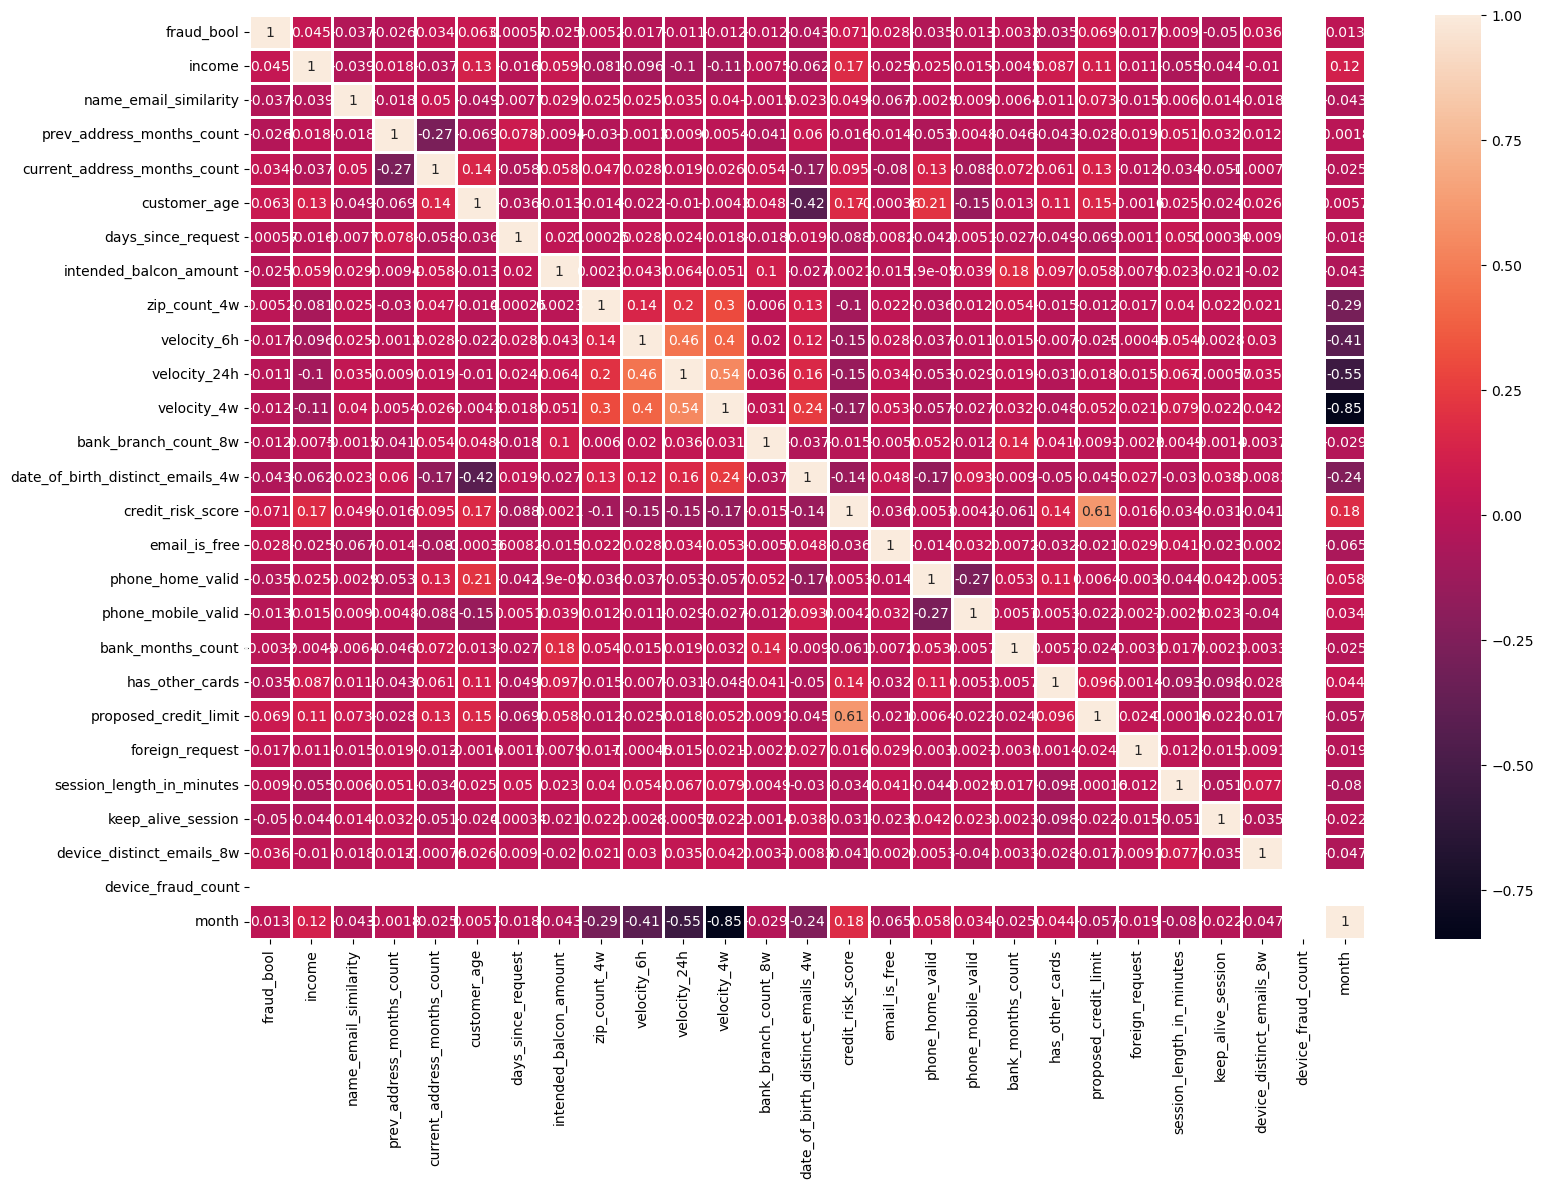

In [5]:
plt.figure(figsize = (18, 12))

# Calculate correlation matrix only for numeric columns
corr = creditcards_df.corr(numeric_only=True)

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [6]:
# Fill missing values
cc_df['intended_balcon_amount'] = cc_df['intended_balcon_amount'].fillna(cc_df['intended_balcon_amount'].mean())
cc_df['velocity_6h'] = cc_df['velocity_6h'].fillna(cc_df['velocity_6h'].mean())
cc_df['credit_risk_score'] = cc_df['credit_risk_score'].fillna(cc_df['credit_risk_score'].mean())

# Fill missing values using loc
cc_df.loc[cc_df['payment_type'].isnull(), 'payment_type'] = 'unknown'
cc_df.loc[cc_df['foreign_request'].isnull(), 'foreign_request'] = 0



C:\Users\Black\AppData\Local\Temp\ipykernel_23700\4141393688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_df['intended_balcon_amount'] = cc_df['intended_balcon_amount'].fillna(cc_df['intended_balcon_amount'].mean())
C:\Users\Black\AppData\Local\Temp\ipykernel_23700\4141393688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_df['velocity_6h'] = cc_df['velocity_6h'].fillna(cc_df['velocity_6h'].mean())
C:\Users\Black\AppData\Local\Temp\ipykernel_23700\4141393688.py:4: SettingWithCopyWarning: 
A

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

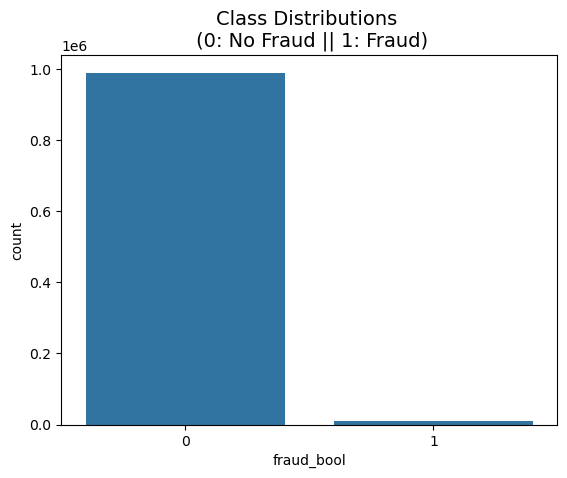

In [7]:
sns.countplot(x='fraud_bool', data=creditcards_df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [8]:
# One-hot encode categorical variable
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
encoded_payment_type = encoder.fit_transform(cc_df[['payment_type']])

# Create DataFrame for encoded columns
encoded_df = pd.DataFrame(encoded_payment_type, columns=encoder.get_feature_names_out(['payment_type']))

# Drop original column and merge encoded data
cc_df = cc_df.drop(columns=['payment_type'])
cc_df = pd.concat([cc_df, encoded_df], axis=1)



Train Split data

In [9]:
# Separate features and target
X = cc_df.drop(columns=['fraud_bool'])
y = cc_df['fraud_bool']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Initialize Min-Max scaler
scaler = MinMaxScaler()

# Scale training and testing features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


LR

In [11]:
# Initialize and train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Predictions for training and testing sets
y_train_hat_log_reg = log_reg.predict(X_train_scaled)
y_test_hat_log_reg = log_reg.predict(X_test_scaled)

# Training and Testing Accuracy
log_reg_train_accuracy = accuracy_score(y_train, y_train_hat_log_reg)
log_reg_test_accuracy = accuracy_score(y_test, y_test_hat_log_reg)

print(f"Logistic Regression Training Accuracy: {log_reg_train_accuracy:.4f}")
print(f"Logistic Regression Testing Accuracy: {log_reg_test_accuracy:.4f}")

# Classification Report and Confusion Matrix for Testing
print("Logistic Regression Classification Report (Testing):\n", classification_report(y_test, y_test_hat_log_reg, zero_division=0))
print("Logistic Regression Confusion Matrix (Testing):\n", confusion_matrix(y_test, y_test_hat_log_reg))


Logistic Regression Training Accuracy: 0.9890
Logistic Regression Testing Accuracy: 0.9890
Logistic Regression Classification Report (Testing):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.00      0.00      0.00      2206

    accuracy                           0.99    200000
   macro avg       0.49      0.50      0.50    200000
weighted avg       0.98      0.99      0.98    200000

Logistic Regression Confusion Matrix (Testing):
 [[197794      0]
 [  2206      0]]


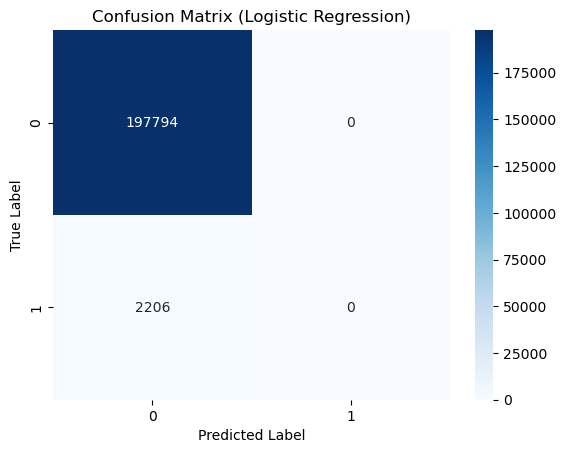

In [12]:
# Confusion matrix for LR
cm_lr = confusion_matrix(y_test, y_test_hat_log_reg)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

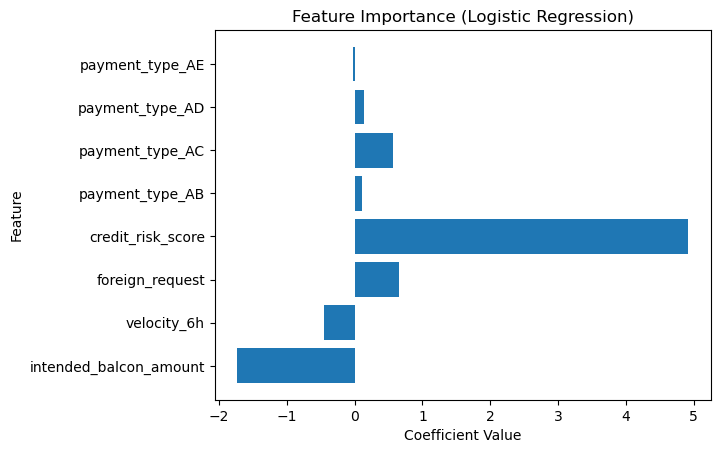

In [13]:
# Visualize coefficients
coefficients = log_reg.coef_[0]
plt.barh(X.columns, coefficients)
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

SVM

In [14]:
# Extract a subset of the training data
X_train_subset = X_train_scaled[:1000]  # Use the first 1000 samples
y_train_subset = y_train[:1000]  # Use the first 1000 labels

# Initialize and train the SVM model on the subset
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_subset, y_train_subset)

# Evaluate the model on the full test set
y_hat_svm = svm_model.predict(X_test_scaled)

# Get the training accuracy
train_accuracy = svm_model.score(X_train_subset, y_train_subset)
print("SVM Training Accuracy (Subset Training):", train_accuracy)

# Get the testing accuracy
test_accuracy = svm_model.score(X_test_scaled, y_test)
print("SVM Testing Accuracy (Subset Training):", test_accuracy)

# Print classification report
print("SVM Classification Report (Subset Training):\n", classification_report(y_test, y_hat_svm, zero_division=0))

# Print confusion matrix
print("SVM Confusion Matrix (Subset Training):\n", confusion_matrix(y_test, y_hat_svm))



SVM Training Accuracy (Subset Training): 0.992
SVM Testing Accuracy (Subset Training): 0.98897
SVM Classification Report (Subset Training):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.00      0.00      0.00      2206

    accuracy                           0.99    200000
   macro avg       0.49      0.50      0.50    200000
weighted avg       0.98      0.99      0.98    200000

SVM Confusion Matrix (Subset Training):
 [[197794      0]
 [  2206      0]]


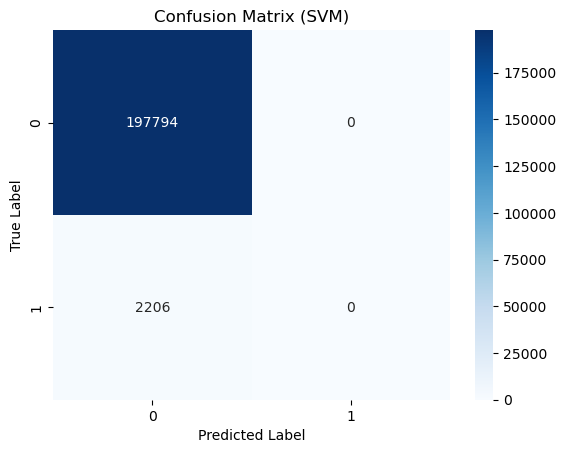

In [15]:
# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_hat_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

